# Imports and Configs

In [1]:
!pip install -q ucimlrepo

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from sklearn.base import clone
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [3]:
TARGET = 'class'
N_FOLDS = 5
SEED = 6
ES_ROUNDS = 50
ES_LOG_STEPS = 250
THRESHOLD = 0.5

# Loading Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

original = fetch_ucirepo(id=848)['data']['original']

In [5]:
train.shape, test.shape

((3116945, 21), (2077964, 20))

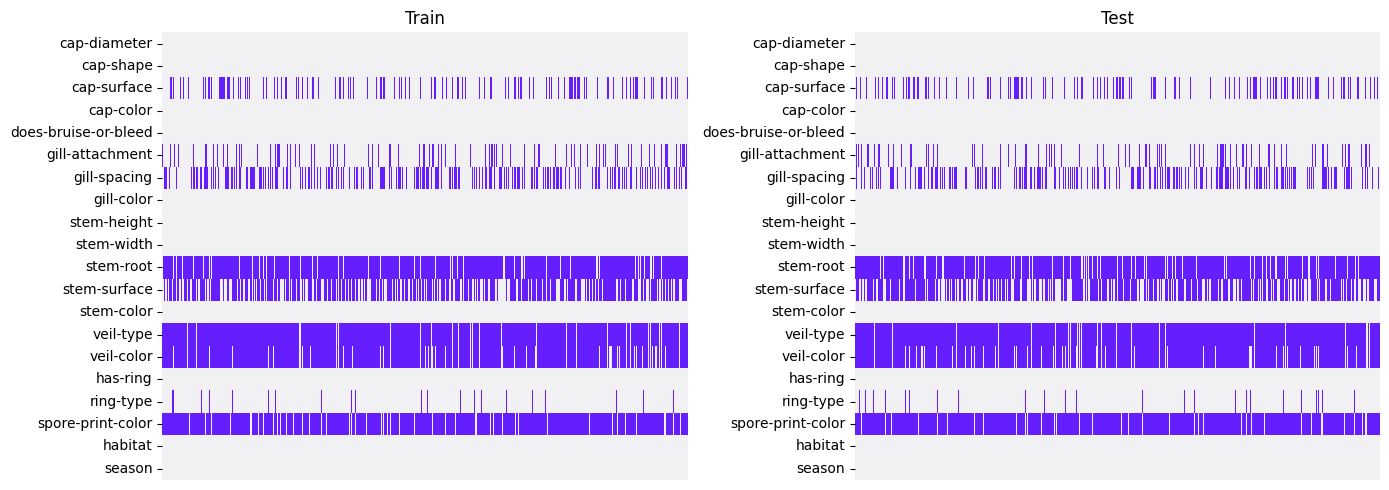

In [6]:
cmap = sns.light_palette('#651FFF', as_cmap=True)

train_null_values = train.sample(100_000).drop(columns=TARGET).isnull().T
test_null_values = test.sample(100_000).isnull().T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

# Feature Engineering

In [7]:
cat_features = test.select_dtypes('object').columns

In [8]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
for feature in cat_features:          
    categories = sorted(list(set(original[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan
    
    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)

In [9]:
X = train.drop([TARGET], axis=1)
y = train[TARGET].map({'e': 0, 'p': 1})
X_test = test

In [10]:
def reduce_mem_usage(dataframe):        
    print('Reducing memory usage')
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            continue

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            dataframe[col] = dataframe[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            dataframe[col] = dataframe[col].astype(np.float32)
        else:
            dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [11]:
X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

Reducing memory usage
--- Memory usage before: 145.66 MB
--- Memory usage after: 92.15 MB
--- Decreased memory usage by 36.7%

Reducing memory usage
--- Memory usage before: 97.11 MB
--- Memory usage after: 61.44 MB
--- Decreased memory usage by 36.7%



# Training

In [12]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)],
                verbose=ES_LOG_STEPS
            )
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            y_preds = y_pred_probs[:, 1] >= THRESHOLD
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            score = matthews_corrcoef(y_val, y_preds)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - MCC: {score:.6f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        print(f'------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        sub[TARGET] = test_pred_probs[:, 1] >= THRESHOLD
        sub[TARGET] = sub[TARGET].map({False: 'e', True: 'p'})
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [13]:
params = {
    "colsample_bylevel": 0.9268202748354142,
    "colsample_bynode": 0.9584021138317574,
    "colsample_bytree": 0.5015612007146208,
    "early_stopping_rounds": ES_ROUNDS,  
    "enable_categorical": True,
    "gamma": 0.3707206931090372,
    "grow_policy": "lossguide",
    "learning_rate": 0.02466371136439142,
    "max_depth": 21,
    "min_child_weight": 0.6117236350232369,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 1.7264475728199302,
    "reg_lambda": 94.37990118781973,
    "subsample": 0.7599216762241778,
    "tree_method": "hist",
    "verbosity": 0
}

model = XGBClassifier(**params)
trainer = Trainer(model)
trainer.fit_predict(X, y, X_test)

Training XGBClassifier

[0]	validation_0-logloss:0.66734
[250]	validation_0-logloss:0.03955
[500]	validation_0-logloss:0.03631
[750]	validation_0-logloss:0.03597
[1000]	validation_0-logloss:0.03585
[1250]	validation_0-logloss:0.03581
[1500]	validation_0-logloss:0.03579
[1532]	validation_0-logloss:0.03579

--- Fold 1 - MCC: 0.984737


[0]	validation_0-logloss:0.66716
[250]	validation_0-logloss:0.03896
[500]	validation_0-logloss:0.03553
[750]	validation_0-logloss:0.03515
[1000]	validation_0-logloss:0.03501
[1250]	validation_0-logloss:0.03494
[1500]	validation_0-logloss:0.03491
[1750]	validation_0-logloss:0.03490
[1885]	validation_0-logloss:0.03490

--- Fold 2 - MCC: 0.985130


[0]	validation_0-logloss:0.66731
[250]	validation_0-logloss:0.03952
[500]	validation_0-logloss:0.03637
[750]	validation_0-logloss:0.03605
[1000]	validation_0-logloss:0.03595
[1250]	validation_0-logloss:0.03590
[1500]	validation_0-logloss:0.03589
[1576]	validation_0-logloss:0.03589

--- Fold 3 - MCC: 0.984831


[0]	